<a href="https://colab.research.google.com/github/LakshmiThirunavukkarasu/Computer-Vision/blob/main/ConvolutionalEncoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
#  article dependencies
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as Datasets
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tqdm.notebook import tqdm
from tqdm import tqdm as tqdm_regular
import seaborn as sns
from torchvision.utils import make_grid
import random

In [25]:
#  configuring device
if torch.cuda.is_available():
  device = torch.device('cuda:0')
  print('Running on the GPU')
else:
  device = torch.device('cpu')
  print('Running on the CPU')

Running on the GPU


In [5]:
!pwd

/content


In [26]:
#  loading training data
training_set = Datasets.CIFAR10(root='./', download=True,
                              transform=transforms.ToTensor())

#  loading validation data
validation_set = Datasets.CIFAR10(root='./', download=True, train=False,
                                transform=transforms.ToTensor())

Files already downloaded and verified
Files already downloaded and verified


In [9]:
training_set.data.shape

(50000, 32, 32, 3)

In [10]:
validation_set.data.shape

(10000, 32, 32, 3)

In [11]:
validation_set.data[0].shape

(32, 32, 3)

In [27]:
def extract_each_class(dataset):
  """
  This function searches for and returns
  one image per class
  """
  images = []
  ITERATE = True
  i = 0
  j = 0

  while ITERATE:
    for label in tqdm_regular(dataset.targets):
      if label==j:
        images.append(dataset.data[i])
        print(f'class {j} found')
        i+=1
        j+=1
        if j==10:
          ITERATE = False
      else:
        i+=1

  return images
  
  


In [28]:
#  extracting training images
training_images = [x for x in training_set.data]
print(training_images[0].shape)
print(len(training_images))

#  extracting validation images
validation_images = [x for x in validation_set.data]
print(validation_images[0].shape)


#  extracting test images for visualization purposes
test_images = extract_each_class(validation_set)
print(test_images[0].shape)
print(len(test_images))

(32, 32, 3)
50000
(32, 32, 3)


100%|██████████| 10000/10000 [00:00<00:00, 1591524.63it/s]

class 0 found
class 1 found
class 2 found
class 3 found
class 4 found
class 5 found
class 6 found
class 7 found
class 8 found
class 9 found
(32, 32, 3)
10


In [29]:
#  defining dataset class
class CustomCIFAR10(Dataset):
  def __init__(self, data, transforms=None):
    self.data = data
    self.transforms = transforms

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    image = self.data[idx]

    if self.transforms!=None:
      image = self.transforms(image)
    return image
    
    
#  creating pytorch datasets
training_data = CustomCIFAR10(training_images, transforms=transforms.Compose([transforms.ToTensor(),
                                                                              transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))
validation_data = CustomCIFAR10(validation_images, transforms=transforms.Compose([transforms.ToTensor(),
                                                                                  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))
test_data = CustomCIFAR10(test_images, transforms=transforms.Compose([transforms.ToTensor(),
                                                                                  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))

In [40]:
training_data[0].shape

torch.Size([3, 32, 32])

In [ ]:
#https://blog.paperspace.com/convolutional-autoencoder/

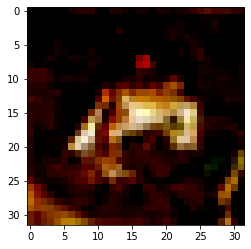

In [43]:
plt.imshow(training_data[0].permute(1,2,0))

In [30]:
#  defining encoder
class Encoder(nn.Module):
  def __init__(self, in_channels=3, out_channels=16, latent_dim=200, act_fn=nn.ReLU()):
    super().__init__()

    self.net = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1), # (32, 32)
        act_fn,
        nn.Conv2d(out_channels, out_channels, 3, padding=1), 
        act_fn,
        nn.Conv2d(out_channels, 2*out_channels, 3, padding=1, stride=2), # (16, 16)
        act_fn,
        nn.Conv2d(2*out_channels, 2*out_channels, 3, padding=1),
        act_fn,
        nn.Conv2d(2*out_channels, 4*out_channels, 3, padding=1, stride=2), # (8, 8)
        act_fn,
        nn.Conv2d(4*out_channels, 4*out_channels, 3, padding=1),
        act_fn,
        nn.Flatten(),
        nn.Linear(4*out_channels*8*8, latent_dim),
        act_fn
    )

  def forward(self, x):
    x = x.view(-1, 3, 32, 32)
    output = self.net(x)
    return output


In [32]:
enc = Encoder()

In [33]:
#  defining decoder
class Decoder(nn.Module):
  def __init__(self, in_channels=3, out_channels=16, latent_dim=200, act_fn=nn.ReLU()):
    super().__init__()

    self.out_channels = out_channels

    self.linear = nn.Sequential(
        nn.Linear(latent_dim, 4*out_channels*8*8),
        act_fn
    )

    self.conv = nn.Sequential(
        nn.ConvTranspose2d(4*out_channels, 4*out_channels, 3, padding=1), # (8, 8)
        act_fn,
        nn.ConvTranspose2d(4*out_channels, 2*out_channels, 3, padding=1, 
                           stride=2, output_padding=1), # (16, 16)
        act_fn,
        nn.ConvTranspose2d(2*out_channels, 2*out_channels, 3, padding=1),
        act_fn,
        nn.ConvTranspose2d(2*out_channels, out_channels, 3, padding=1, 
                           stride=2, output_padding=1), # (32, 32)
        act_fn,
        nn.ConvTranspose2d(out_channels, out_channels, 3, padding=1),
        act_fn,
        nn.ConvTranspose2d(out_channels, in_channels, 3, padding=1)
    )

  def forward(self, x):
    output = self.linear(x)
    output = output.view(-1, 4*self.out_channels, 8, 8)
    output = self.conv(output)
    return output

In [34]:
#  defining autoencoder
class Autoencoder(nn.Module):
  def __init__(self, encoder, decoder):
    super().__init__()
    self.encoder = encoder
    self.encoder.to(device)

    self.decoder = decoder
    self.decoder.to(device)

  def forward(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

In [35]:
class ConvolutionalAutoencoder():
  def __init__(self, autoencoder):
    self.network = autoencoder
    self.optimizer = torch.optim.Adam(self.network.parameters(), lr=1e-3)

  def train(self, loss_function, epochs, batch_size, 
            training_set, validation_set, test_set):
    
    #  creating log
    log_dict = {
        'training_loss_per_batch': [],
        'validation_loss_per_batch': [],
        'visualizations': []
    } 

    #  defining weight initialization function
    def init_weights(module):
      if isinstance(module, nn.Conv2d):
        torch.nn.init.xavier_uniform_(module.weight)
        module.bias.data.fill_(0.01)
      elif isinstance(module, nn.Linear):
        torch.nn.init.xavier_uniform_(module.weight)
        module.bias.data.fill_(0.01)

    #  initializing network weights
    self.network.apply(init_weights)

    #  creating dataloaders
    train_loader = DataLoader(training_set, batch_size)
    val_loader = DataLoader(validation_set, batch_size)
    test_loader = DataLoader(test_set, 10)

    #  setting convnet to training mode
    self.network.train()
    self.network.to(device)

    for epoch in range(epochs):
      print(f'Epoch {epoch+1}/{epochs}')
      train_losses = []

      #------------
      #  TRAINING
      #------------
      print('training...')
      for images in tqdm(train_loader):
        #  zeroing gradients
        self.optimizer.zero_grad()
        #  sending images to device
        images = images.to(device)
        #  reconstructing images
        output = self.network(images)
        #  computing loss
        loss = loss_function(output, images.view(-1, 3, 32, 32))
        #  calculating gradients
        loss.backward()
        #  optimizing weights
        self.optimizer.step()

        #--------------
        # LOGGING
        #--------------
        log_dict['training_loss_per_batch'].append(loss.item())

      #--------------
      # VALIDATION
      #--------------
      print('validating...')
      for val_images in tqdm(val_loader):
        with torch.no_grad():
          #  sending validation images to device
          val_images = val_images.to(device)
          #  reconstructing images
          output = self.network(val_images)
          #  computing validation loss
          val_loss = loss_function(output, val_images.view(-1, 3, 32, 32))

        #--------------
        # LOGGING
        #--------------
        log_dict['validation_loss_per_batch'].append(val_loss.item())


      #--------------
      # VISUALISATION
      #--------------
      print(f'training_loss: {round(loss.item(), 4)} validation_loss: {round(val_loss.item(), 4)}')

      for test_images in test_loader:
        #  sending test images to device
        test_images = test_images.to(device)
        with torch.no_grad():
          #  reconstructing test images
          reconstructed_imgs = self.network(test_images)
        #  sending reconstructed and images to cpu to allow for visualization
        reconstructed_imgs = reconstructed_imgs.cpu()
        test_images = test_images.cpu()

        #  visualisation
        imgs = torch.stack([test_images.view(-1, 3, 32, 32), reconstructed_imgs], 
                          dim=1).flatten(0,1)
        grid = make_grid(imgs, nrow=10, normalize=True, padding=1)
        grid = grid.permute(1, 2, 0)
        plt.figure(dpi=170)
        plt.title('Original/Reconstructed')
        plt.imshow(grid)
        log_dict['visualizations'].append(grid)
        plt.axis('off')
        plt.show()
      
    return log_dict

  def autoencode(self, x):
    return self.network(x)

  def encode(self, x):
    encoder = self.network.encoder
    return encoder(x)
  
  def decode(self, x):
    decoder = self.network.decoder
    return decoder(x)

In [36]:
Enc = Encoder()


Epoch 1/10
training...


  0%|          | 0/782 [00:00<?, ?it/s]

validating...


  0%|          | 0/157 [00:00<?, ?it/s]

training_loss: 0.0523 validation_loss: 0.0572


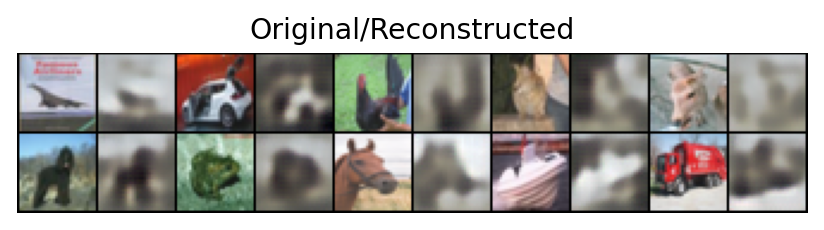

Epoch 2/10
training...


  0%|          | 0/782 [00:00<?, ?it/s]

validating...


  0%|          | 0/157 [00:00<?, ?it/s]

training_loss: 0.0297 validation_loss: 0.0399


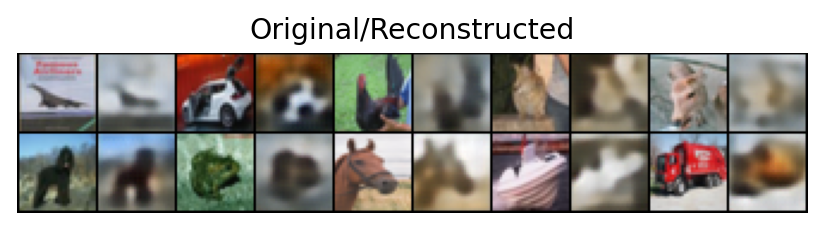

Epoch 3/10
training...


  0%|          | 0/782 [00:00<?, ?it/s]

validating...


  0%|          | 0/157 [00:00<?, ?it/s]

training_loss: 0.0266 validation_loss: 0.0339


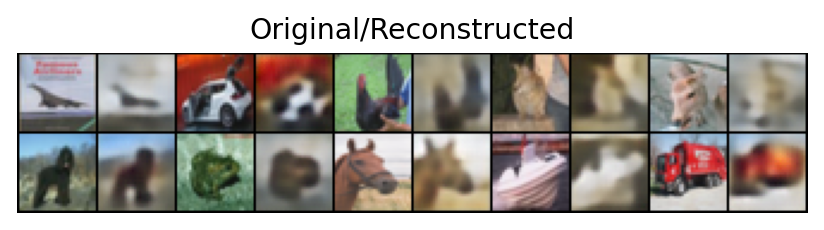

Epoch 4/10
training...


  0%|          | 0/782 [00:00<?, ?it/s]

validating...


  0%|          | 0/157 [00:00<?, ?it/s]

training_loss: 0.0234 validation_loss: 0.0311


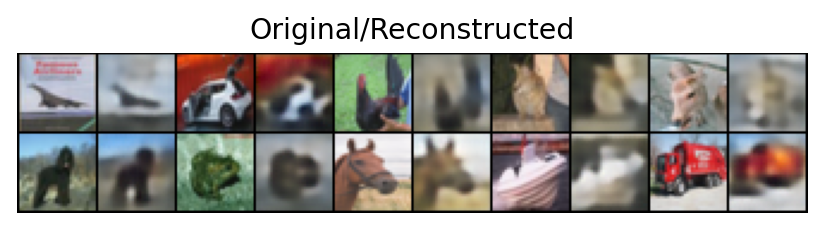

Epoch 5/10
training...


  0%|          | 0/782 [00:00<?, ?it/s]

validating...


  0%|          | 0/157 [00:00<?, ?it/s]

training_loss: 0.0215 validation_loss: 0.0288


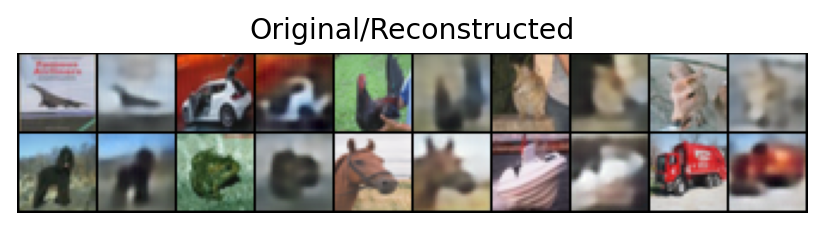

Epoch 6/10
training...


  0%|          | 0/782 [00:00<?, ?it/s]

validating...


  0%|          | 0/157 [00:00<?, ?it/s]

training_loss: 0.0184 validation_loss: 0.0241


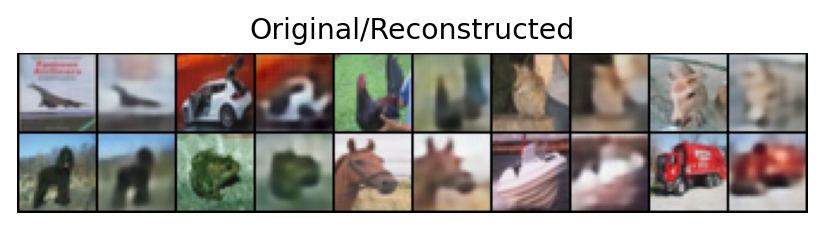

Epoch 7/10
training...


  0%|          | 0/782 [00:00<?, ?it/s]

validating...


  0%|          | 0/157 [00:00<?, ?it/s]

training_loss: 0.0174 validation_loss: 0.023


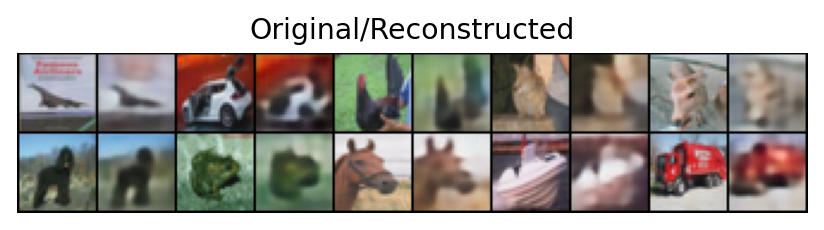

Epoch 8/10
training...


  0%|          | 0/782 [00:00<?, ?it/s]

validating...


  0%|          | 0/157 [00:00<?, ?it/s]

training_loss: 0.016 validation_loss: 0.0211


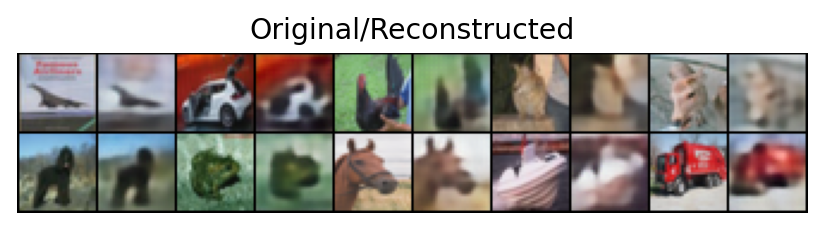

Epoch 9/10
training...


  0%|          | 0/782 [00:00<?, ?it/s]

validating...


  0%|          | 0/157 [00:00<?, ?it/s]

training_loss: 0.0157 validation_loss: 0.0204


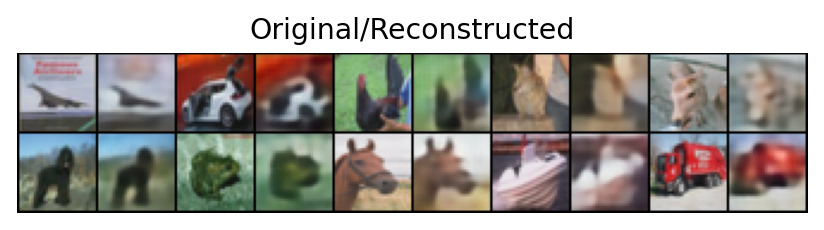

Epoch 10/10
training...


  0%|          | 0/782 [00:00<?, ?it/s]

validating...


  0%|          | 0/157 [00:00<?, ?it/s]

training_loss: 0.0155 validation_loss: 0.0196


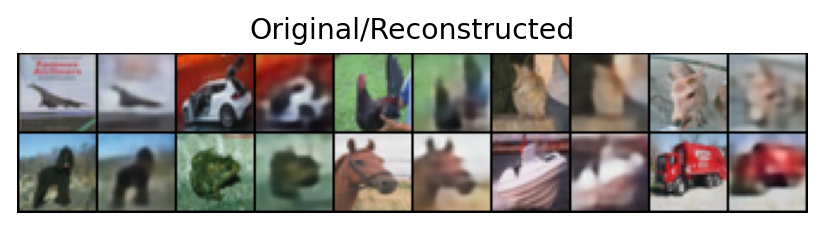

In [37]:
#  training model

model = ConvolutionalAutoencoder(Autoencoder(Encoder(), Decoder()))

log_dict = model.train(nn.MSELoss(), epochs=10, batch_size=64, 
                       training_set=training_data, validation_set=validation_data,
                       test_set=test_data)

# New Section